# Identyfikacja oddziaływań neutrin w detektorach ciekłoargonowych metodami uczenia maszynowego

## 2. Analiza wygenerowanych danych

Pliki tau_data.csv i mu_data.csv przygotowane zgodnie ze skryptem eksport_danych.ipynb zawierają informację o rodzaju, pędach i energii każdego z naładowanych końcowych produktów oddziaływań. Pliki te należy wczytać oraz umieścić dane dotyczące każdego z oddziaływań w osobnej macierzy biblioteki numpy. Następnie selekcjonowane są jedynie oddziaływania o dwóch produktach końcowych. Ostatecznym wynikiem jest lista wektorów o długości 10 zawierających pęd podłużny, poprzeczny i całkowity każdej z cząstek, a także ich energie oraz kąt między ich torami. Ostatnim parametrem jest kąt między torem mionu, a osią OZ. Dodatkowo zapisywana jest również lista liczności cząstek w każdym z oddziaływań w celu wykreślenia histogramu krotności.

In [1]:
import numpy as np
import csv

# Funkcja do liczenia kąta między dwoma wektorami
def angle(a, b):
    dot_product = np.dot(a, b)
    length_a = np.linalg.norm(a)
    length_b = np.linalg.norm(b)
    return np.arccos(dot_product / (length_a * length_b))

#Funkcja przyjmuje plik .csv w którym każdy wiersz to [nr, pid1, px1, py1, pz1, E1, pid2, px2, py2, pz2, E2]
#itd. dla wszystkich naładowanych produktów końcowych
def loading_data(file, angle_func):
    with open(file, 'r') as f:
        final_data = []
        reader = csv.reader(f)
        particles_count = [] # Lista zbierająca dane do histogramu krotności cząstek w oddziaływaniach
        for row in reader:
            event = []
            #Tworzenie macierzy w której każdy wiersz to kod, pędy i energia kolejnej cząstki
            particles = np.array(row[1:], dtype=float).reshape(-1, 5)
            #Odrzucenie cząstek o pędach zerowych pojawiających sie w wygenerowanym pliku
            particles = particles[~np.all(particles[:, 1:] == 0., axis=1)]
            #Wykorzystujemy tylko oddziaływania, w których wśród produktów występuje mion
            if 13 in particles[:, 0]:
                if len(particles) > 1:
                    for particle in particles:
                        pid, px, py, pz, E = particle
                        momentum = np.linalg.norm([px, py, pz])
                        xy_momentum = np.linalg.norm([px, py])
                        event.append([E, pid, px, py, pz, xy_momentum, momentum])
                    particles_count.append(len(event))
                    if len(event) == 2:
                        event = np.array(event)
                        if event[:, 1][0] == 13:
                            event = event[[1, 0]] # Każda macierz zawiera parametry mionu w drugim wierszu
                        # Obliczanie kąta między cząstkami w macierzy
                        angle = angle_func(event[0][2:5], event[1][2:5])
                        # Obliczanie kąta między mionem i osią OZ którą poruszało się neutrino
                        theta = angle_func([0, 0, 1], event[1][2:5])
                        energy = event[0][0] + event[1][0]
                        event = event[:,4:] # Odrzucenie niepotrzebnych danych -- kodu pdg oraz pędu w x i y
                        event = np.append(event, angle * 180 / np.pi).reshape(1, 7)
                        event = np.append(event, theta * 180 / np.pi).reshape(1, 8)
                        event = np.append(event, energy).reshape(1, 9)
                        final_data.append(event)
    return final_data, particles_count

In [2]:
mu_data, mu_particles_count = loading_data('mu_data.csv', angle)
tau_data, tau_particles_count = loading_data('tau_data.csv', angle)

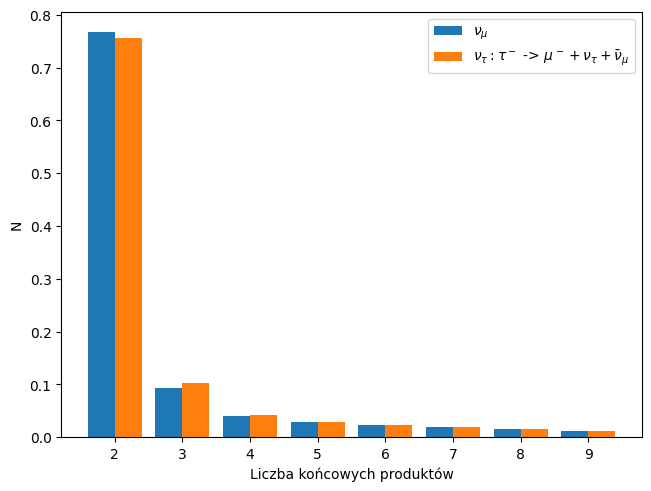

In [3]:
import matplotlib.pyplot as plt

# Histogram krotności cząstek w oddziaływaniach
tau_hist = np.histogram(tau_particles_count, bins=np.arange(1.5, 10.5, 1), density = True)[0]
mu_hist = np.histogram(mu_particles_count, bins=np.arange(1.5, 10.5, 1), density = True)[0]

x = np.arange(2, 10)
fig, ax = plt.subplots(layout='constrained')
ax.bar(x - 0.2, mu_hist, 0.4, label=r'$\nu_\mu$')
ax.bar(x + 0.2, tau_hist, 0.4, label=r'$\nu_\tau: \tau^-$ -> $\mu^- + \nu_\tau + \bar\nu_\mu$')
ax.set_ylabel('N')
ax.set_xlabel('Liczba końcowych produktów')
ax.legend()
plt.show()

Dla tak przygotowanych danych można obliczyć korelacje między dwoma dowolnymi parametrami. Obliczany jest wynik testu r Pearsona oraz tworzony wykres rozrzutu

In [4]:
# Słownik zawierający parametry takie jak opisy osi i zakresy danych na wykresie dla każdej badanej danej
parameter_dict = {'pz_p': [0, 'pęd podłużny protonu [GeV]', (0, 2.5)], 
                  'pxy_p': [1, 'pęd poprzeczny protonu [GeV]', (0, 1.6)], 
                  'p_p': [2, 'pęd całkowity protonu [GeV]', (0, 2.5)], 
                  'pz_mu': [3, r'pęd podłużny $\mu^-$ [GeV]', (0, 7)], 
                  'pxy_mu': [4, r'pęd poprzeczny $\mu^-$ [GeV]', (0, 2.1)], 
                  'p_mu': [5, r'pęd całkowity $\mu^-$ [GeV]', (0, 7)],  
                  'alpha': [6, r'kąt $\alpha$ między $\mu^-$ i $p$', (0, 180)], 
                  'theta': [7, r'kąt $\theta$ między $\mu^-$ i $\nu$', (0, 75)], 
                  'E': [8, r'Suma energii $p$ i $\mu^-$ [GeV]', (0, 8.5)]}

In [5]:
import scipy

def correlation(mu_data, tau_data, parameter1, parameter2, parameter_dict):
    first = []
    second = []
    for event in mu_data[0:1000]:
        first.append(event[0][parameter_dict[parameter1][0]])
        second.append(event[0][parameter_dict[parameter2][0]])
    print(f'Pearson r: {scipy.stats.pearsonr(first, second)[0]:0.2f}')
    plt.scatter(first, second, marker = '.')
    plt.xlabel(parameter_dict[parameter1][1])
    plt.ylabel(parameter_dict[parameter2][1])
    plt.show()

Pearson r: 1.00


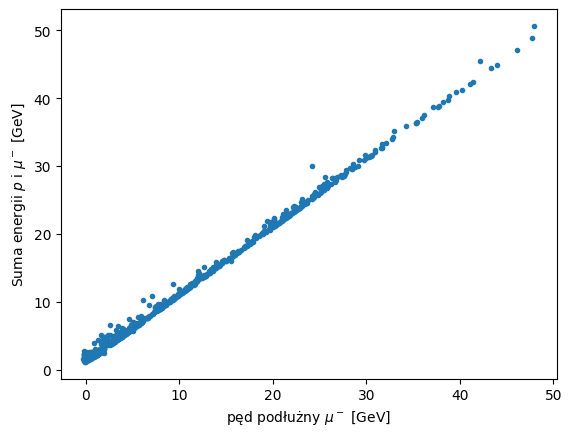

In [6]:
'''
dostępne parametry:
pęd całkowity mionu - 'p_mu'
pęd podłużny mionu - 'pz_mu'
pęd poprzeczny mionu - 'pxy_mu'
ped całkowity protonu - 'p_p'
pęd podłużny protonu - 'pz_mu'
pęd poprzeczny protonu - 'pxy_mu'
kąt alpha - 'alpha'
kąt theta - 'theta'
energia widzialna = 'E'
'''

correlation(mu_data, tau_data, 'pz_mu', 'E', parameter_dict)

Następnie po wybraniu interesujących parametrów można przejść do wykreślenia histogramów porównujących każdy z parametrów w przypadku oddziaływań neutrin mionowych i taonowych

In [7]:
def histograms(mu_data, tau_data, parameter, parameter_dict, axs):
    idx, x_label, hist_range = parameter_dict[list(parameter_dict.keys())[parameter]]
    tau_quantity_list = []
    mu_quantity_list = []
    for i in tau_data:
        tau_quantity_list.append(i[0][idx])
    for i in mu_data:
        mu_quantity_list.append(i[0][idx])
    mu, edges = np.histogram(mu_quantity_list, bins = 50, range = hist_range)
    tau = np.histogram(tau_quantity_list, bins = 50, range = hist_range)[0]
    mu_hist = [mu[i] / len(mu_quantity_list) for i in range(len(mu))]
    tau_hist = [tau[i] / len(tau_quantity_list) for i in range(len(tau))]
    w = edges[2] - edges[1]
    centers = [(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]
    axs[parameter%3].bar(centers, mu_hist, width = w, alpha = 0.8, label=r'$\nu_\mu + n$ -> $\mu^- + p$')
    axs[parameter%3].bar(centers, tau_hist, width = w, alpha = 0.8, linewidth = 1, 
                         label=r'$\nu_\tau + n$ -> $\tau^- + p$ -> $\mu^- + \nu_\tau + \bar\nu_\mu + p$')
    axs[parameter%3].set_xlabel(x_label)
    axs[parameter%3].set_ylabel('N')
    if parameter == 2:
        axs[parameter%3].legend()

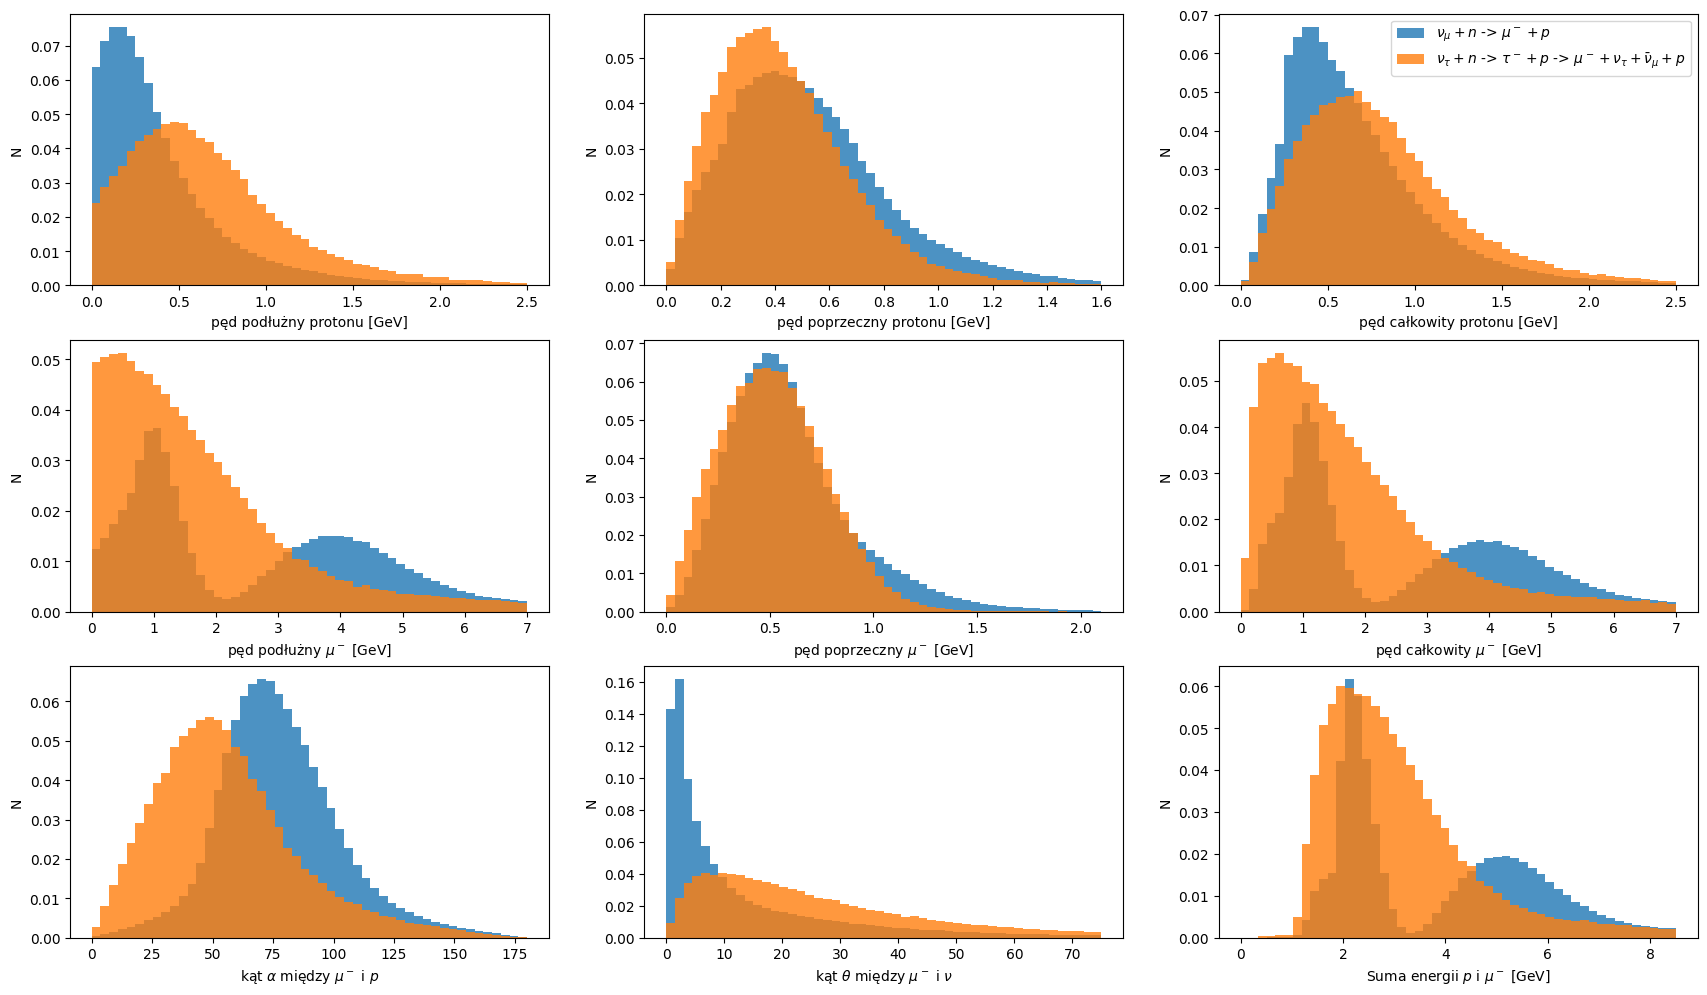

In [8]:
fig, [axs1, axs2, axs3] = plt.subplots(3, 3, figsize=(21, 12))
for i in range(0, 3): 
    histograms(mu_data, tau_data, i, parameter_dict, axs1)
for i in range(3, 6): 
    histograms(mu_data, tau_data, i, parameter_dict, axs2)
for i in range(6, 9): 
    histograms(mu_data, tau_data, i, parameter_dict, axs3)